In [144]:
%matplotlib notebook

In [145]:
import requests
import json

from census import Census
from us import states

from config import apikey
from config import gkey

import gmaps
gmaps.configure(api_key=gkey)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [146]:
#API calls census using wrapper
c = Census(apikey, year=2017)
census_data = c.acs5.get(("B01003_001E","B01002_001E"),{'for': 'county:*', 'in': 'state:*' })

#converting to dataFrame
census_pd = pd.DataFrame(census_data)

#Renaming the columns
census_pd=census_pd.rename(columns={"B01003_001E":"Total Population","B01002_001E":"Median Age","state":"fips"})

#extracting state population from census data

Population=census_pd.groupby('fips')['Total Population'].sum()
final_fips=census_pd.groupby('fips')['fips'].first()

state_population=pd.DataFrame({"Total Population":Population,"State Fips":final_fips})
state_population.loc[:,'State Fips']=state_population["State Fips"].astype('int64')

In [147]:
zip_path="Resources/state_fips_master.csv"
zip_df=pd.read_csv(zip_path)
zip_df=zip_df.rename(columns={"fips":"State Fips"})

#Merging the census_pd with state_zip_df to obtain state_name column in Census dataFrame
Census_df=pd.merge(state_population,zip_df,on="State Fips")
Census_df=Census_df.rename(columns={"State Fips":"fips","state_name":"State Name"})
Census_df.head()

,Total Population,fips,State Name,state_abbr,long_name,sumlev,region,division,state,region_name,division_name
0,4850771.0,1,Alabama,AL,Alabama AL,40,3,6,1,South,East South Central
1,738565.0,2,Alaska,AK,Alaska AK,40,4,9,2,West,Pacific
2,6809946.0,4,Arizona,AZ,Arizona AZ,40,4,8,4,West,Mountain
3,2977944.0,5,Arkansas,AR,Arkansas AR,40,3,7,5,South,West South Central
4,38982847.0,6,California,CA,California CA,40,4,9,6,West,Pacific


In [148]:
csv_path = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"

# Read the CSV into a Pandas DataFrame
covid_df = pd.read_csv(csv_path)

In [149]:
#Covid-19 Data on County level

#extracting latest information from the live data
cases_covid=covid_df.groupby(['fips','county','state'])['cases'].last()
deaths_covid=covid_df.groupby(['fips','county','state'])['deaths'].last()
date_covid=covid_df.groupby(['fips','county','state'])['date'].last()
fips_covid=covid_df.groupby(['fips','county','state'])['fips'].first()
state_covid=covid_df.groupby(['fips','county','state'])['state'].first()
county_covid=covid_df.groupby(['fips','county','state'])['county'].first()

#creating new dataframe
County_Covid_df=pd.DataFrame({"Date":date_covid,
                             "County":county_covid,
                             "Total Number of Covid-19 Cases":cases_covid,
                             "Death due to Covid-19":deaths_covid})

In [150]:
state_path = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"
state_df=pd.read_csv(state_path)
state_df=state_df.rename(columns={'date':'Date','state':'State Name','cases':'Total Covid-19 Cases','deaths':'Total Deaths Covid-19'})
state_df.head()

,Date,State Name,fips,Total Covid-19 Cases,Total Deaths Covid-19
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [151]:
#Covid-19 Data on State Level

cases_state=state_df.groupby(['State Name'])['Total Covid-19 Cases'].sum()
deaths_state=state_df.groupby(['State Name'])['Total Deaths Covid-19'].sum()
date_state=state_df.groupby(['State Name'])['Date'].last()

State_Covid_df=pd.DataFrame({"Date":date_state,"Total Covid-19 Cases":cases_state,"Total Deaths Covid-19":deaths_state})
State_Covid_df=State_Covid_df.reset_index()
State_Covid_df.head()

,State Name,Date,Total Covid-19 Cases,Total Deaths Covid-19
0,Alabama,2020-04-15,44906,1097
1,Alaska,2020-04-15,4124,75
2,American Samoa,2020-04-15,0,0
3,Arizona,2020-04-15,48232,1374
4,Arkansas,2020-04-15,20039,345


In [152]:
#Merging 'Total population per state' with 'covid parameters on state level'
complete_df=pd.merge(State_Covid_df,Census_df,on='State Name')
complete_df=complete_df[["Date","State Name","Total Covid-19 Cases","Total Deaths Covid-19","Total Population","fips"]]

In [153]:
#Adding Latitude and Longitude for HeatMap
latlng_path="Resources/statelatlong.csv"
latlng_df=pd.read_csv(latlng_path)
latlng_df=latlng_df.rename(columns={"City":"State Name"})
HeatMap_df=pd.merge(latlng_df,complete_df,on="State Name")

In [154]:
#Calculating state mortality rates

mortality_df=(HeatMap_df['Total Deaths Covid-19']/HeatMap_df['Total Population'])*100000
HeatMap_df['Mortality per 100,000']=mortality_df
HeatMap_df.head()

,State,Latitude,Longitude,State Name,Date,Total Covid-19 Cases,Total Deaths Covid-19,Total Population,fips,"Mortality per 100,000"
0,AL,32.601011,-86.680736,Alabama,2020-04-15,44906,1097,4850771.0,1,22.614962
1,AK,61.302501,-158.775020,Alaska,2020-04-15,4124,75,738565.0,2,10.154827
2,AZ,34.168219,-111.930907,Arizona,2020-04-15,48232,1374,6809946.0,4,20.176371
3,AR,34.751928,-92.131378,Arkansas,2020-04-15,20039,345,2977944.0,5,11.585174
4,CA,37.271875,-119.270415,California,2020-04-15,335461,8694,38982847.0,6,22.302117


In [155]:
import time
date=time.strftime('%x')
Total_Cases_US=HeatMap_df['Total Covid-19 Cases'].sum()
Total_Covid_Deaths_US=HeatMap_df['Total Deaths Covid-19'].sum()
print(f"Total covid Cases reported as of {date} are {Total_Cases_US}")
print(f"Total covid Cases reported as of {date} are {Total_Covid_Deaths_US}")

Total covid Cases reported as of 04/16/20 are 7498560
Total covid Cases reported as of 04/16/20 are 249030


In [156]:
sort_cases_df=HeatMap_df.sort_values('Total Covid-19 Cases',ascending=False)
sort_cases_df.head()

,State,Latitude,Longitude,State Name,Date,Total Covid-19 Cases,Total Deaths Covid-19,Total Population,fips,"Mortality per 100,000"
31,NY,40.705626,-73.979680,New York,2020-04-15,2711786,103787,19798228.0,36,524.223683
29,NJ,40.143006,-74.731116,New Jersey,2020-04-15,804900,24779,8960161.0,34,276.546370
4,CA,37.271875,-119.270415,California,2020-04-15,335461,8694,38982847.0,6,22.302117
21,MI,44.943560,-86.415805,Michigan,2020-04-15,330639,16403,9925568.0,26,165.260064
20,MA,42.062940,-71.718067,Massachusetts,2020-04-15,304816,7758,6789319.0,25,114.267720


<IPython.core.display.Javascript object>


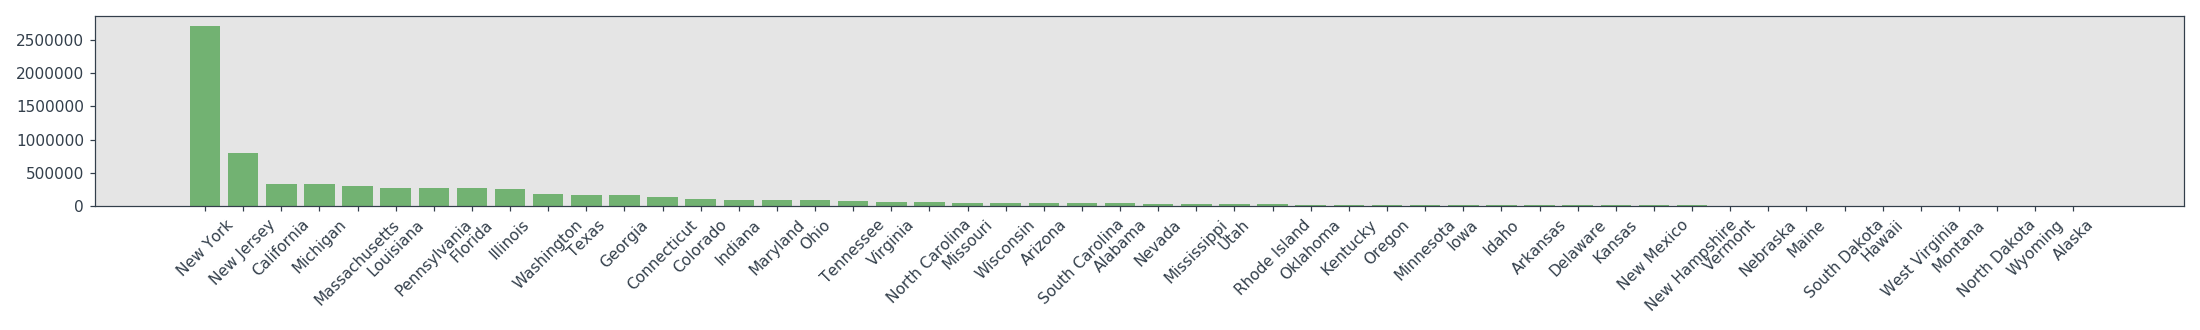

In [157]:
#visualising states with maximum deathhs
x_axis = np.arange(len(sort_cases_df))
tick_locations = [value for value in x_axis]

# Create a list indicating where to write x labels and set figure size to adjust for space
plt.figure(figsize=(20,3))
plt.bar(x_axis,sort_cases_df["Total Covid-19 Cases"], color='g', alpha=0.5, align="center")
plt.xticks(tick_locations, sort_cases_df["State Name"], rotation=45)
plt.grid(False)
plt.tight_layout()
plt.savefig("Charts/CovidCases.png")
plt.show()

In [158]:
sort_deaths_df=HeatMap_df.sort_values('Total Deaths Covid-19',ascending=False)
sort_deaths_df.head()

,State,Latitude,Longitude,State Name,Date,Total Covid-19 Cases,Total Deaths Covid-19,Total Population,fips,"Mortality per 100,000"
31,NY,40.705626,-73.979680,New York,2020-04-15,2711786,103787,19798228.0,36,524.223683
29,NJ,40.143006,-74.731116,New Jersey,2020-04-15,804900,24779,8960161.0,34,276.546370
21,MI,44.943560,-86.415805,Michigan,2020-04-15,330639,16403,9925568.0,26,165.260064
17,LA,30.973377,-91.429910,Louisiana,2020-04-15,271103,10827,4663461.0,22,232.166625
4,CA,37.271875,-119.270415,California,2020-04-15,335461,8694,38982847.0,6,22.302117


<IPython.core.display.Javascript object>


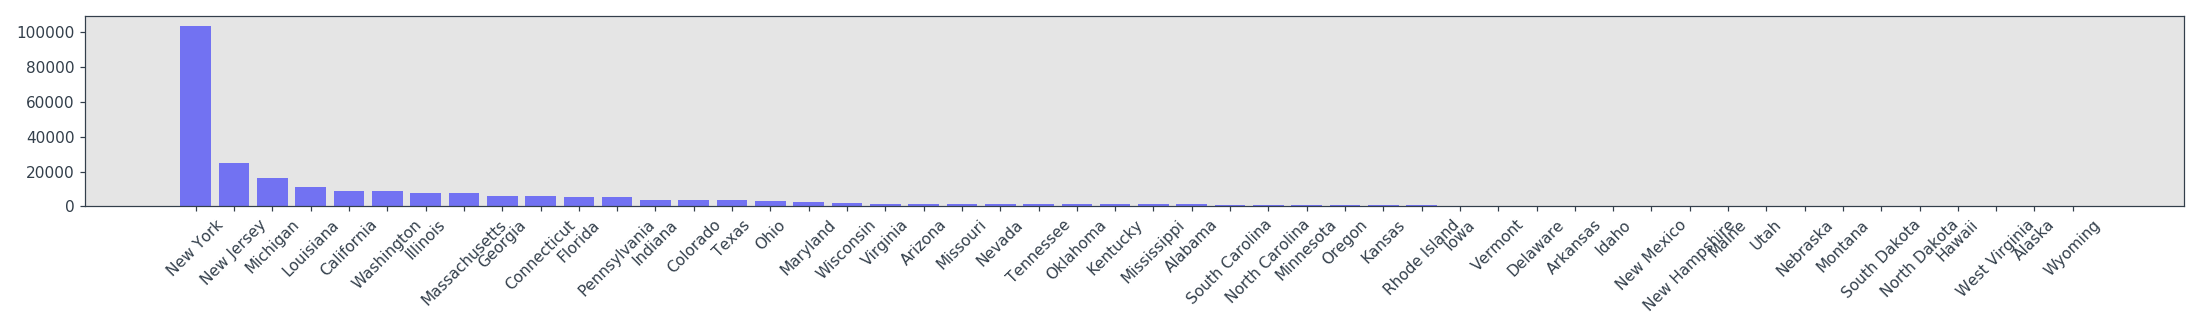

In [159]:
#visualising states with maximum cases
x_axis1 = np.arange(len(sort_deaths_df))
tick_locations1 = [value for value in x_axis1]

# Create a list indicating where to write x labels and set figure size to adjust for space
plt.figure(figsize=(20,3))
plt.bar(x_axis1,sort_deaths_df["Total Deaths Covid-19"], color='b', alpha=0.5,align="center")
plt.xticks(tick_locations1, sort_deaths_df["State Name"], rotation=45)
plt.grid(False)
plt.tight_layout()
plt.savefig("Charts/CovidDeaths.png")
plt.show()

<IPython.core.display.Javascript object>


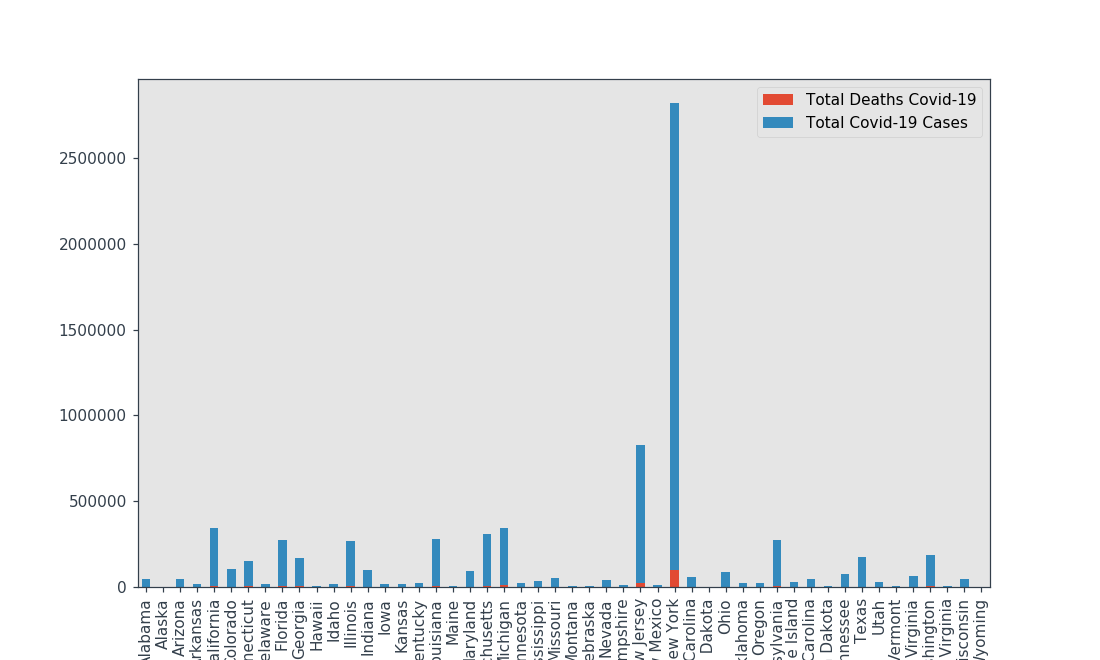

In [161]:
#StackedBar for Total Cases and Total Deaths

pivot_df=HeatMap_df[['State Name','Total Deaths Covid-19','Total Covid-19 Cases']]
pivot_df=pivot_df.set_index('State Name')

stack_fig= pivot_df[['Total Deaths Covid-19','Total Covid-19 Cases']].plot(kind="bar",figsize=(10,6), stacked=True)
plt.grid(False)
plt.savefig("Charts/StackedBar.png")

In [162]:
#Covid 'Mortality per 100,000' per state in the USA

locations = HeatMap_df[["Latitude", "Longitude"]]

# Plot Heatmap
Covid = gmaps.figure()

impact=HeatMap_df['Mortality per 100,000']

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=impact, dissipating=False, max_intensity=10,point_radius=1)

# Add layer
Covid.add_layer(heat_layer)

# Display figure
Covid



Figure(layout=FigureLayout(height='420px'))

# Dataset name: COVID-19 Hospital Needs and Death Projections
Source=http://www.healthdata.org/covid/data-downloads

*allbed_mean= Mean covid beds needed by day
*ICUbed_mean= Mean ICU covid beds needed by day
*InvVen_mean= Mean invasive ventilation needed by day
*deaths_mean= Mean daily covid deaths
*admis_mean= Mean hospital admissions by day
*newICU_mean= Mean number of new people going to the ICU by day
*totdea_mean= Mean cumulative covid deaths
*bedover_mean= covid all beds needed-(total bed capacity-average all bed usage)
*icuover_mean= covid ICU beds needed-(total ICU capacity-average ICU bed usage)

In [184]:
hospital_csv='Resources/Hospitalization_all_locs.csv'
hospital_df=pd.read_csv(hospital_csv)
hospital_df=hospital_df[['location_name','date','allbed_mean',
                         'ICUbed_mean','InvVen_mean',
                         'deaths_mean','admis_mean',
                         'newICU_mean','totdea_mean','bedover_mean',
                         'icuover_mean']]

hospital_df=hospital_df.rename(columns={'location_name':'State Name',"allbed_mean":'Covid beds',
                               'ICUbed_mean':'ICU_covid beds',"InvVen_mean":'Ventilators',
                                "deaths_mean":'Covid Deaths',"admis_mean":'Hospital Admits',
                                'newICU_mean':'New ICU Admits','totdea_mean':'Total Covid Deaths'})

As_day_forecast=hospital_df.loc[hospital_df['date']=='2020-04-27']

In [191]:
Readiness_df=pd.merge(As_day_forecast,Census_df,on='State Name')
Readiness_df=Readiness_df.set_index('State Name')
Mainland_readiness_df=Readiness_df.drop(['Alaska','Hawaii'])
Mainland_readiness_df.head()

,date,Covid beds,ICU_covid beds,Ventilators,Covid Deaths,Hospital Admits,New ICU Admits,Total Covid Deaths,bedover_mean,icuover_mean,Total Population,fips,state_abbr,long_name,sumlev,region,division,state,region_name,division_name
State Name,,,,,,,,,,,,,,,,,,,,
Wyoming,2020-04-27,103.609253,17.583179,15.669206,1.725,16.529137,3.045708,9.526,0.0,0.0,583200.0,56,WY,Wyoming WY,40,4,8,56,West,Mountain
Wisconsin,2020-04-27,235.280734,65.734124,49.196635,4.980,10.695442,2.766692,340.173,0.0,0.0,5763217.0,55,WI,Wisconsin WI,40,2,3,55,Midwest,East North Central
West Virginia,2020-04-27,60.193587,16.483110,12.475261,1.184,3.784231,0.865781,67.300,0.0,0.0,1836843.0,54,WV,West Virginia WV,40,3,5,54,South,South Atlantic
Washington,2020-04-27,487.820298,119.191365,92.321707,9.761,34.590431,7.624975,791.589,0.0,0.0,7169967.0,53,WA,Washington WA,40,4,9,53,West,Pacific
Virginia,2020-04-27,1183.414952,233.285046,195.586934,21.238,154.168497,29.046530,425.004,0.0,0.0,8365952.0,51,VA,Virginia VA,40,3,5,51,South,South Atlantic


In [186]:
import geopandas as gpd
shapefile='data/cb_2018_us_state_500k.shp'
gdf = gpd.read_file(shapefile)[['NAME','geometry']]
gdf.columns=['State Name','geometry']

#Merging geodataframe and dataframe 
Covid_Visual = gdf.merge(Mainland_readiness_df, left_on = 'State Name', right_on = 'State Name')

<IPython.core.display.Javascript object>


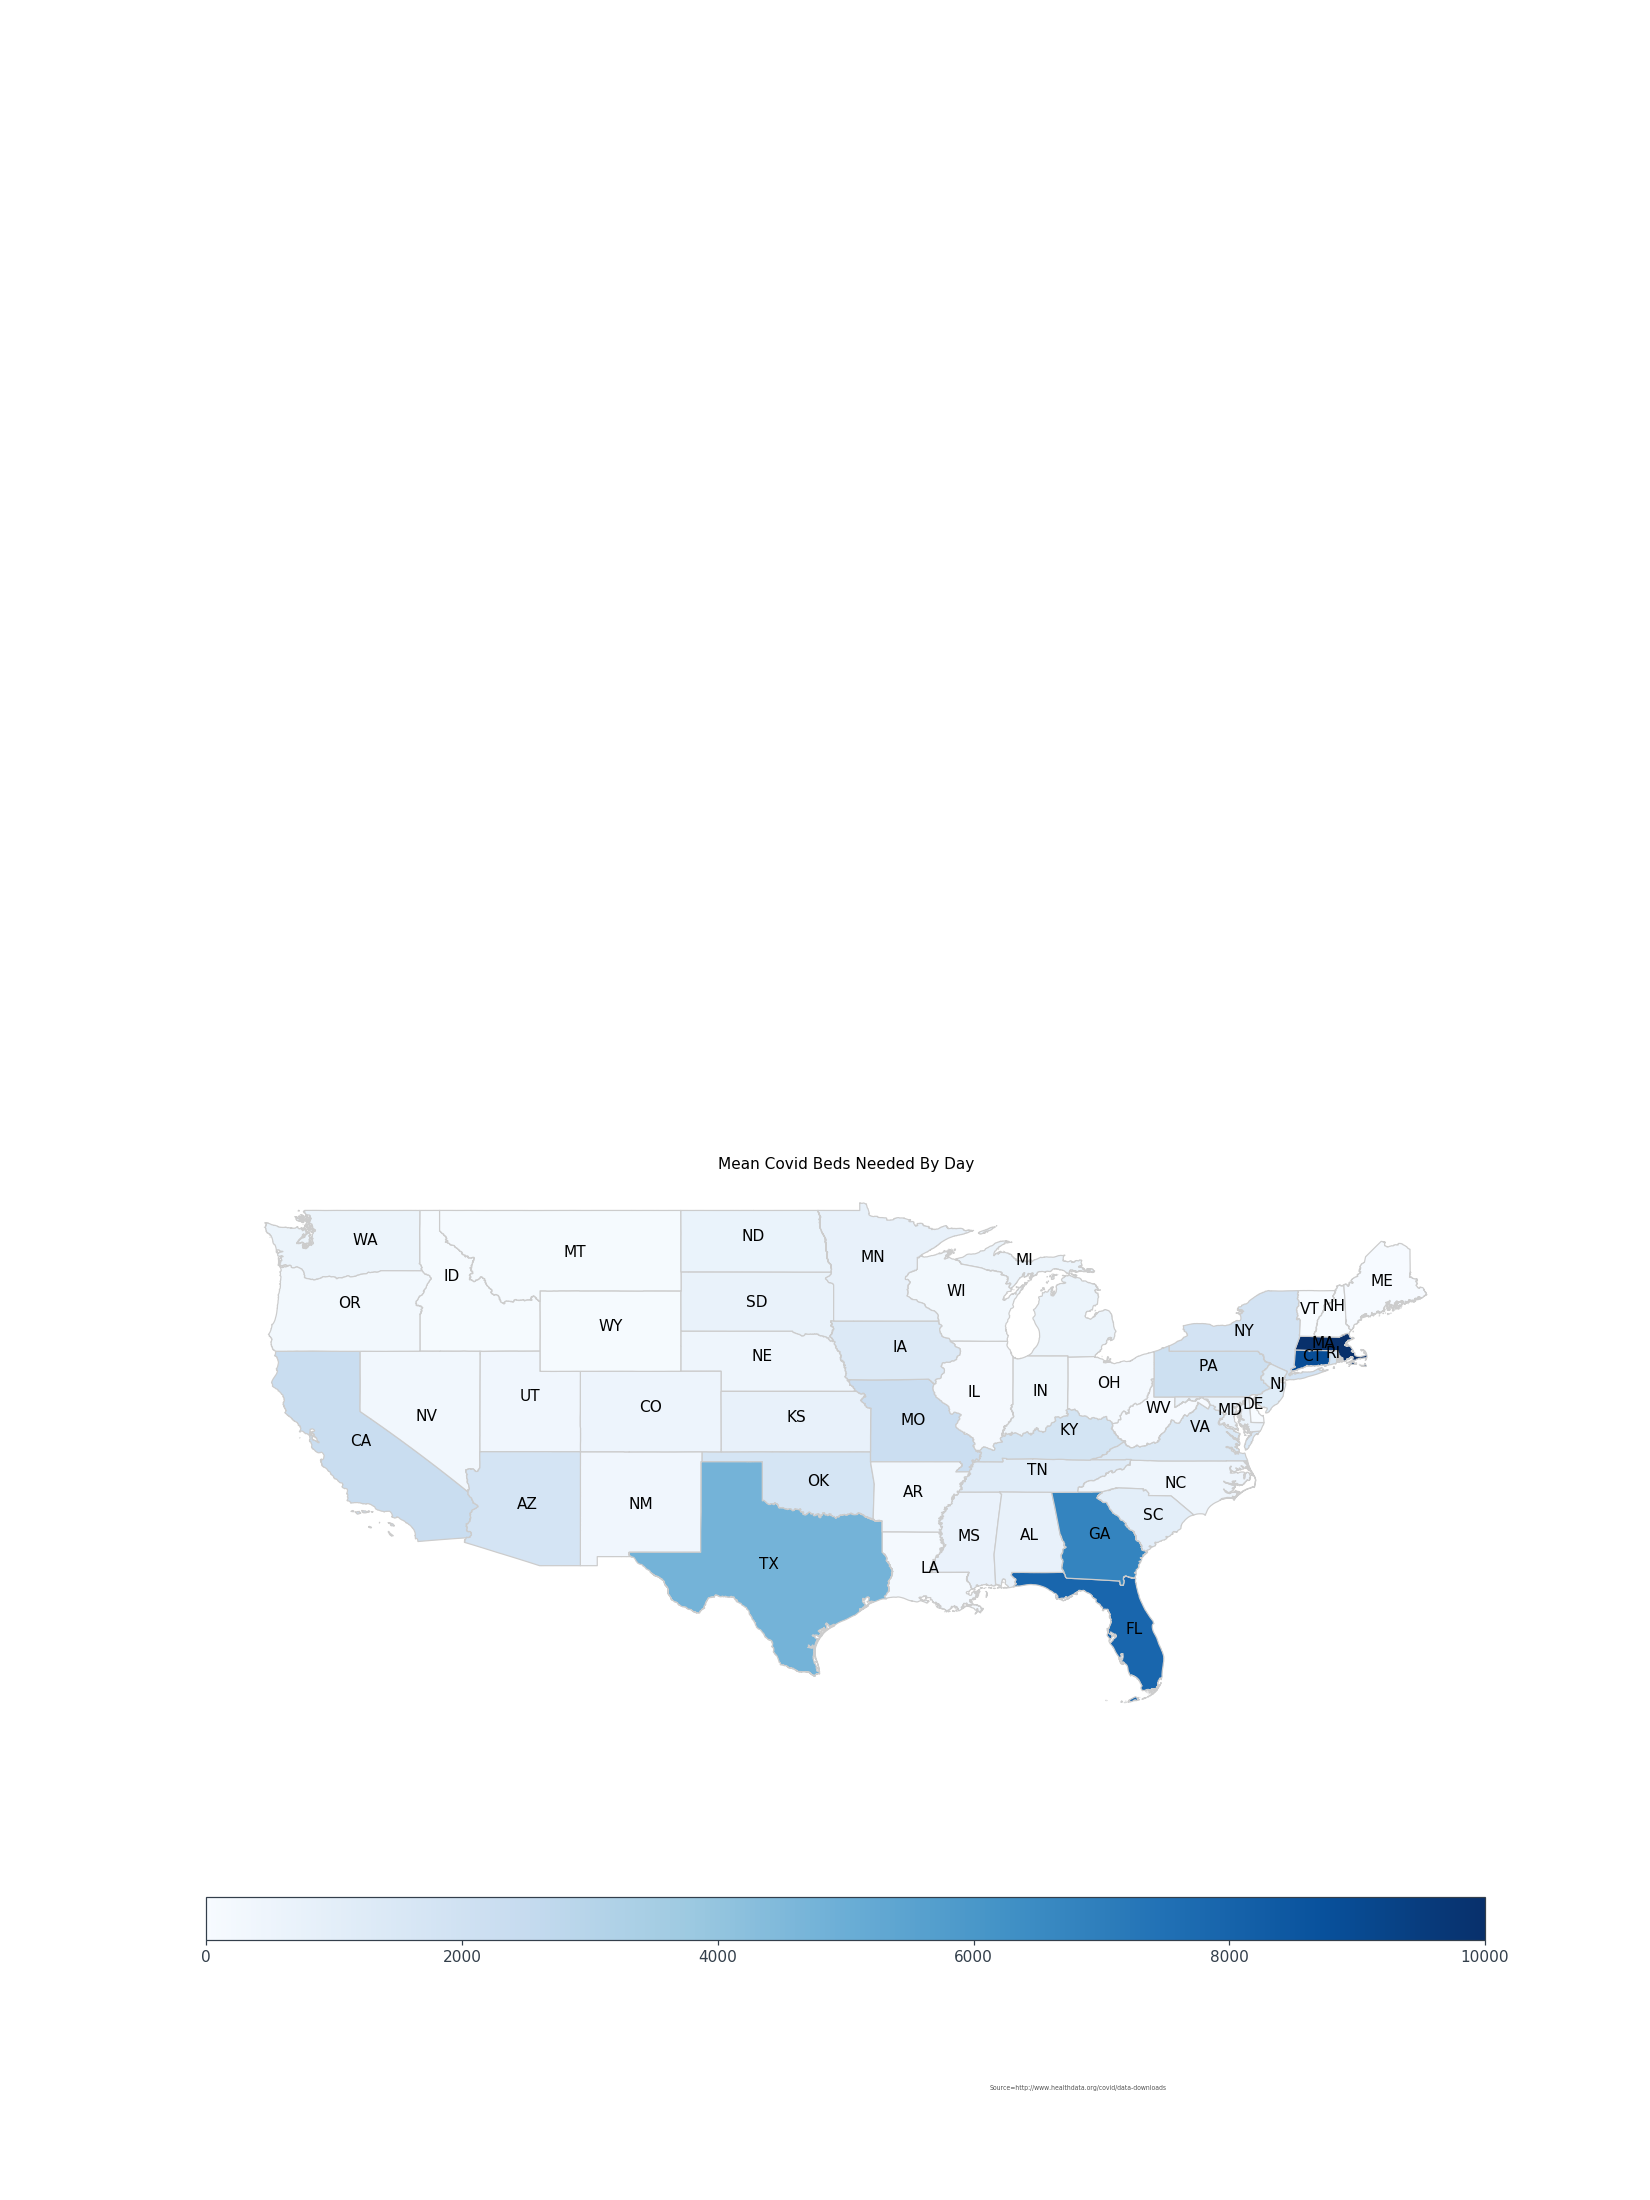

In [199]:
#value to be visualised
variable='Covid beds'

# set the range for the choropleth values
vmin, vmax = 0, 10000

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 20))

# remove the axis
ax.axis('off')

# add a title and annotation
ax.set_title('Mean Covid Beds Needed By Day', fontdict={'fontsize': '10'})
ax.annotate('Source=http://www.healthdata.org/covid/data-downloads', xy=(0.6, .05), xycoords='figure fraction', fontsize=4, color='#555555')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm.set_array([]) 

# create map
Covid_Visual.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

# Add Labels
Covid_Visual['coords'] = Covid_Visual['geometry'].apply(lambda x: x.representative_point().coords[:])
Covid_Visual['coords'] = [coords[0] for coords in Covid_Visual['coords']]

for idx, row in Covid_Visual.iterrows():
    plt.annotate(s=row['state_abbr'], xy=row['coords'],horizontalalignment='center')
            
fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30)

fig.savefig("Charts/CovidBeds.png", dpi=300)